In [6]:
import os
print(os.getcwd())

/teamspace/studios/this_studio


In [2]:
import torchvision.transforms as transforms
from PIL import Image

# Example usage
image_path = "test.jpg"

# Define the transformation
resize = transforms.Resize((512, 512))  # Specify the new height and width

# Read the image
image = Image.open(image_path)

# Apply the transformation
resized_image = resize(image)

# Display or save the resized image
resized_image.save('test.jpg') 

In [2]:
import cv2
import numpy as np
from PIL import Image
from torchvision.io import read_image
import torchvision.transforms as transforms

def pil_to_grayscale_tensor(image):
    grayscale_transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor()
    ])
    return grayscale_transform(image)

def filter_noise_from_mask(binary_mask, min_component_size):
    """
    Remove small polygons from the binary mask.
    
    Args:
    - binary_mask (numpy array): The binary mask to be cleaned.
    - min_component_size (int): The minimum size of components to keep.
    
    Returns:
    - filtered_mask (numpy array): The cleaned binary mask.
    """
    # Perform Connected Component Analysis
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(binary_mask.astype(np.uint8), connectivity=8)
    
    # Filter components based on size
    filtered_mask = np.zeros_like(binary_mask)
    for label in range(1, num_labels):
        component_size = stats[label, cv2.CC_STAT_AREA]
        if component_size >= min_component_size:
            filtered_mask[labels == label] = 1
    
    return filtered_mask

def clean_and_save_mask(mask_path, output_path, min_component_size=500):
    """
    Read a binary mask from a file, clean it, and save the cleaned mask.
    
    Args:
    - mask_path (str): Path to the input binary mask file.
    - output_path (str): Path to save the cleaned binary mask.
    - min_component_size (int): The minimum size of components to keep.
    """
    # Read the binary mask image
    mask_pil = Image.open(mask_path).convert('L')  # Ensure the mask is in grayscale
    mask_tensor = pil_to_grayscale_tensor(mask_pil)
    mask = mask_tensor.numpy().squeeze()

    # Filter noise from the mask
    cleaned_mask = filter_noise_from_mask(mask, min_component_size)
    
    # Save the cleaned binary mask
    cleaned_mask_img = Image.fromarray((cleaned_mask * 255).astype(np.uint8))
    cleaned_mask_img.save(output_path)

# Example usage
mask_path = 'Deeplab/check.jpg'
output_path = 'cleaned_mask.jpg'
clean_and_save_mask(mask_path, output_path, min_component_size=500)


In [3]:
import torchvision.transforms as transforms
from PIL import Image

# Example usage
image_path = 'Deeplab/check.jpg'

# Define the transformation
resize = transforms.Resize((512, 512))  # Specify the new height and width

# Read the image
image = Image.open(image_path)

# Apply the transformation
resized_image = resize(image)

# Display or save the resized image
resized_image.save('Deeplab/check.jpg') 

In [4]:
import numpy as np
import cv2
import pydensecrf.densecrf as dcrf
from pydensecrf.utils import unary_from_softmax, create_pairwise_gaussian, create_pairwise_bilateral
from PIL import Image
from torchvision.io import read_image, write_jpeg
import torch
import torchvision.transforms as transforms

def apply_dense_crf(img, mask):
    """
    Applies DenseCRF to refine the segmentation mask.
    
    Args:
    - img (numpy array): The original image.
    - mask (numpy array): The initial segmentation mask.
    
    Returns:
    - refined_mask (numpy array): The refined segmentation mask.
    """
    # Convert image to numpy array if it's a tensor
    if isinstance(img, torch.Tensor):
        img = img.numpy().transpose(1, 2, 0)

    # Get height and width of image
    h, w = img.shape[:2]

    # Ensure mask is a 2D array
    if mask.ndim == 3 and mask.shape[0] == 1:
        mask = mask[0]
    elif mask.ndim == 3 and mask.shape[0] == 3:  # In case the mask is RGB
        mask = mask[0]

    # Ensure mask has the same height and width as the image
    assert mask.shape == (h, w), f"Mask shape {mask.shape} does not match image shape {(h, w)}"

    # Initialize DenseCRF
    d = dcrf.DenseCRF2D(w, h, 2)

    # Create unary potentials
    mask = mask.astype(np.float32) / 255.0  # Normalize mask to range [0, 1]
    unary = np.stack([mask, 1 - mask], axis=0)  # Swapped to correctly represent foreground and background
    unary = unary.reshape((2, -1))  # Shape should be (num_classes, height*width)
    d.setUnaryEnergy(unary)

    # Create pairwise potentials
    pairwise_gaussian = create_pairwise_gaussian(sdims=(3, 3), shape=img.shape[:2])
    d.addPairwiseEnergy(pairwise_gaussian, compat=3)

    pairwise_bilateral = create_pairwise_bilateral(sdims=(50, 50), schan=(13, 13, 13), img=img, chdim=2)
    d.addPairwiseEnergy(pairwise_bilateral, compat=10)

    # Perform inference
    Q = d.inference(5)
    refined_mask = np.argmax(Q, axis=0).reshape((h, w))

    return refined_mask

def clean_and_save_mask_with_crf(mask_path, img_path, output_path):
    """
    Read a binary mask and image from files, clean the mask using DenseCRF, and save the cleaned mask.
    
    Args:
    - mask_path (str): Path to the input binary mask file.
    - img_path (str): Path to the original image file.
    - output_path (str): Path to save the cleaned binary mask.
    """
    # Read the binary mask image
    mask = read_image(mask_path).numpy().squeeze()  # Assuming the mask is a single channel image
    if mask.ndim == 3 and mask.shape[0] == 1:  # If there's an extra channel dimension
        mask = mask[0]
    
    # Read the original image
    img = np.array(Image.open(img_path).convert('RGB'))

    # Apply DenseCRF to refine the mask
    refined_mask = apply_dense_crf(img, mask)

    # Save the cleaned binary mask
    cleaned_mask_img = Image.fromarray((refined_mask * 255).astype(np.uint8))
    cleaned_mask_img.save(output_path)

# Example usage
mask_path = 'Deeplab/check.jpg'
img_path = 'test.jpg'
output_path = 'cleaned_mask_with_crf.jpg'
clean_and_save_mask_with_crf(mask_path, img_path, output_path)


Matplotlib created a temporary cache directory at /tmp/matplotlib-dtym1fpo because the default path (/teamspace/studios/this_studio/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


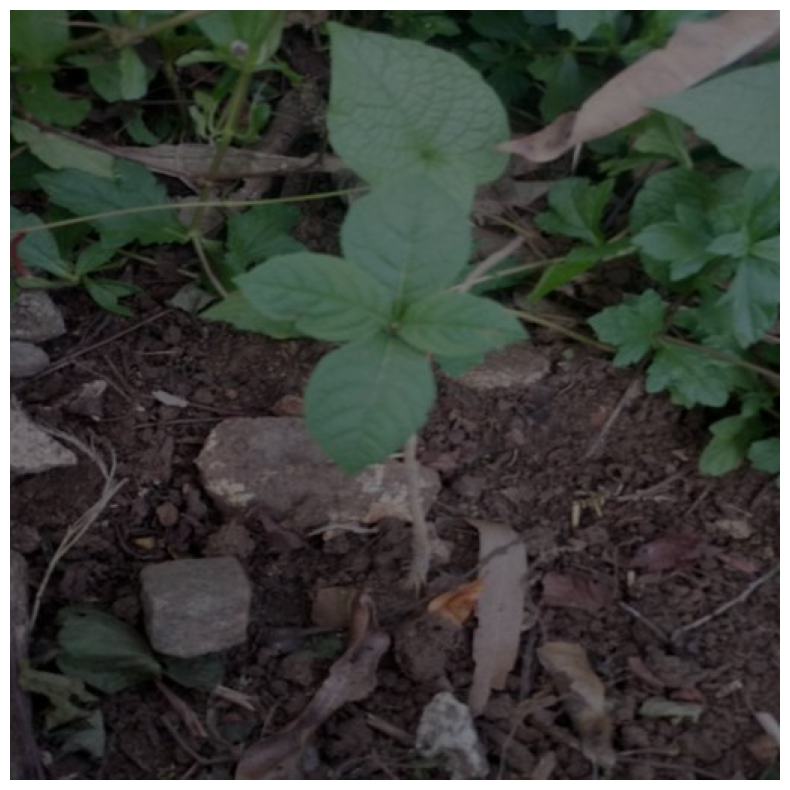

In [5]:
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Load the original image
img = Image.open('/teamspace/studios/this_studio/test.jpg').convert('RGB')

# Load the binary mask as a blue image
#binary_mask = cv2.imread('cleaned_mask_with_crf.jpg', cv2.IMREAD_GRAYSCALE)

binary_mask = cv2.imread('cleaned_mask_with_crf.jpg', cv2.IMREAD_GRAYSCALE)
_, binary_mask = cv2.threshold(binary_mask, 127, 255, cv2.THRESH_BINARY)
binary_mask_blue = cv2.cvtColor(binary_mask, cv2.COLOR_GRAY2BGR)
binary_mask_blue[:, :, 0] = 0  # Set red channel to 0
binary_mask_blue[:, :, 1] = 0  # Set green channel to 0

# Convert binary mask to a NumPy array with True (255) and False (0) values
binary_array = (binary_mask == 255)

# Set the size of the plot
plt.figure(figsize=(10, 10))  # Adjust the width and height as needed

# Overlay the binary mask on the original image
plt.imshow(img)
plt.imshow(binary_mask_blue, alpha=0.5)
plt.axis('off')

# Remove ticks
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())

# Save the figure
plt.savefig('/teamspace/studios/this_studio/test_overlayed.jpg', bbox_inches='tight', pad_inches=0)
plt.show()
plt.close()


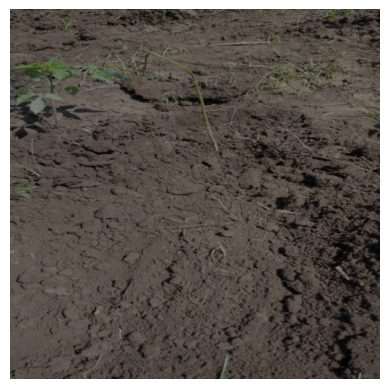

In [44]:
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Load the original image
img = Image.open('/teamspace/studios/this_studio/test.jpg').convert('RGB')

# Load the binary mask as a blue image
binary_mask = cv2.imread('cleaned_mask_with_crf.jpg', cv2.IMREAD_GRAYSCALE)
_, binary_mask = cv2.threshold(binary_mask, 127, 255, cv2.THRESH_BINARY)
binary_mask_blue = cv2.cvtColor(binary_mask, cv2.COLOR_GRAY2BGR)
binary_mask_blue[:, :, 0] = 0  # Set red channel to 0
binary_mask_blue[:, :, 1] = 0  # Set green channel to 0

# Convert binary mask to a NumPy array with True (255) and False (0) values
binary_array = (binary_mask == 255)

# Overlay the binary mask on the original image
plt.imshow(img)
plt.imshow(binary_mask_blue, alpha=0.5)
plt.axis('off')

# Remove ticks
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())

# Save the figure
plt.savefig('/teamspace/studios/this_studio/test_overlayed.jpg', bbox_inches='tight', pad_inches=0)
plt.show()
plt.close()


In [1]:
#Deeplab/saved_models/india_sam_dino_250_samples_0.8924413878050058.pth
# Deeplab/saved_models/india_sam_dino_250_samples_0.8495187035894669.pth
%cd /teamspace/studios/this_studio/Deeplab/

from torch.utils.data import dataset
from tqdm import tqdm
import network
import utils
import os
import random
import argparse
import numpy as np
from torch.utils import data
from datasets import VOCSegmentation, Cityscapes, cityscapes, LeafDataset
from torchvision import transforms as T
from metrics import StreamSegMetrics, BinarySegMetrics
import torch
import torch.nn as nn
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
from glob import glob
import random
import loralib as lora
from PIL import Image

inhouse_default = '/teamspace/studios/this_studio/Deeplab/saved_models/best_deeplabv3plus_mobilenet_custom_os16_0.7854892764326529.pth'
downstreamed_large = '/teamspace/studios/this_studio/Deeplab/saved_models/india_sam_dino_250_samples_0.8495187035894669.pth'
downstreamed_small = '/teamspace/studios/this_studio/Deeplab/saved_models/india_sam_dino_250_samples_0.8940880817269634.pth'
downstreamed_tuned = '/teamspace/studios/this_studio/Deeplab/saved_models/base_sam_dino_india_tuned_freetown_eastafrica_haiti_0.8213798905479425.pth'

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


/teamspace/studios/this_studio/Deeplab


Matplotlib created a temporary cache directory at /tmp/matplotlib-yovf2cey because the default path (/teamspace/studios/this_studio/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [10]:
def decode_target(mask):
  leaf_color = [255, 255, 255]
  rgb_mask = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
  rgb_mask[mask == 1] = leaf_color
  return Image.fromarray(rgb_mask)

def show(image):
  sample = Image.open(image)
  plt.imshow(sample)
  plt.axis("off")
  plt.show()

img_transform = T.Compose([
              T.Resize((512, 512)),
              T.ToTensor(),
              T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
          ])

mask_transform = T.Compose([
              T.Resize((512, 512), interpolation=T.InterpolationMode.NEAREST),
              T.ToTensor(),
          ])

def load_deeplab_model(ckpt, model_type = 'deeplabv3plus_mobilenet', num_classes= 1, output_stride= 16):
  os.environ['CUDA_VISIBLE_DEVICES'] = '0'
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  print("Device: %s" % device)

  model = network.modeling.__dict__[model_type](num_classes, output_stride)
  network.convert_to_separable_conv(model.classifier)
  utils.set_bn_momentum(model.backbone, momentum=0.01)
  checkpoint = torch.load(ckpt, map_location=torch.device('cpu'))
  model.load_state_dict(checkpoint["model_state"])
  model = nn.DataParallel(model)
  model.to(device)
  print("Resume model from %s" % ckpt)
  del checkpoint
  return model, device
    

def get_target(mask_path):
  mask = Image.open(mask_path)
  mask_array = np.array(mask)
  mask_array = (mask_array > 128).astype(np.uint8)
  mask_array = mask_array * 255
  mask = Image.fromarray(mask_array.astype(np.uint8))
  mask = mask_transform(mask)
  mask = torch.squeeze(mask, 0)
  mask = mask.to(device, dtype=torch.long)
  mask = mask.float()
  return mask.cpu().numpy()

def get_exif(image_path):
    try:
        image = Image.open(image_path)

        for orientation in ExifTags.TAGS.keys():
            if ExifTags.TAGS[orientation] == 'Orientation':
                break

        exif = image._getexif()

        if exif and orientation in exif:
            print(exif[orientation])

        image.save(output_path)
        image.close()
    except Exception as e:
        print('no tag found or something went wrong')
        pass

def create_histogram(confidence, region, species):

  # list of bins
  bins = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.95, 1]
  plt.hist(confidence, bins=bins, edgecolor='black')

  if species == None:
    plt.title(region  + ', Image Count - ' + str(len(confidence)))
  else:
    plt.title(region + ' - ' + species + ', Image Count - ' + str(len(confidence)))

  # plotting labelled histogram
  plt.xlabel('Model Confidence')
  plt.ylabel('Image Count')
  plt.show()
'''
def generate(region):
  region_species = []
  for i in inhouse_trained_samples:
    if i.startswith(region):
      region_species.append(os.path.basename(i).split('_')[1].upper())

  region_species = list(set(region_species))
  region_main_list = region_rand_list(region, region_species)
  region_confidence_list = model_confidence(region_main_list, download = True)
  create_histogram(region_confidence_list, region, species = None)
'''




"\ndef generate(region):\n  region_species = []\n  for i in inhouse_trained_samples:\n    if i.startswith(region):\n      region_species.append(os.path.basename(i).split('_')[1].upper())\n\n  region_species = list(set(region_species))\n  region_main_list = region_rand_list(region, region_species)\n  region_confidence_list = model_confidence(region_main_list, download = True)\n  create_histogram(region_confidence_list, region, species = None)\n"

In [12]:
def get_overlayed_mask(checkpoint, to_download, use_url = True, save_binary_mask = True):
      metrics = BinarySegMetrics()
      # Denormalising samples for generating overlayed masks
      denorm = utils.Denormalize(mean=[0.485, 0.456, 0.406],
                                        std=[0.229, 0.224, 0.225])
    
      with torch.no_grad():
          device = load_deeplab_model(checkpoint)[1]
          model = load_deeplab_model(checkpoint)[0].eval()
          if use_url:
              b = '/teamspace/studios/this_studio/test.jpg'
              !wget -q $to_download -O $b
          #else:
              #my_bucket.download_file(to_download, '/teamspace/studios/this_studio/test.jpg')
              
          img = Image.open('/teamspace/studios/this_studio/test.jpg').convert('RGB')
          img = img_transform(img).unsqueeze(0).to(device, dtype=torch.float32)
          output = model(img)
          img = img[0].detach().cpu().numpy()
          img = (denorm(img) * 255).transpose(1, 2, 0).astype(np.uint8)
          output = torch.squeeze(output, dim=1)
          prob = torch.sigmoid(output).detach()
          pred = (prob > 0.5).long().cpu().numpy()
          pred = pred[0]
          prob = prob[0]
          prob = prob.cpu().numpy()
          count = np.sum(prob > 0.5) 
          sum = np.sum(prob[prob > 0.5])
          if count == 0:
              print('nothing detected')
          else:
              show('/teamspace/studios/this_studio/test.jpg')
              print('Confidence is ' + str(sum/count))
              plt.imshow(img)
              plt.imshow(img)
              plt.imshow(pred, alpha=0.7)
              plt.axis('off')
            
            # Remove ticks
              plt.gca().xaxis.set_major_locator(plt.NullLocator())
              plt.gca().yaxis.set_major_locator(plt.NullLocator())
            
            # Save the figure
              plt.savefig('/teamspace/studios/this_studio/test_overlayed.jpg', bbox_inches='tight', pad_inches=0)
              plt.close()
              show('/teamspace/studios/this_studio/test_overlayed.jpg')
          if save_binary_mask:
              pred_rgb = np.array(decode_target(pred)).astype(np.uint8)
              pred_image = Image.fromarray(pred_rgb).convert('RGB')
              pred_image.save('check.jpg')
        
 


In [14]:
import os
import torch
import torch.nn as nn
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms

def load_deeplab_model(ckpt, device, model_type='deeplabv3plus_mobilenet', num_classes=1, output_stride=16):
    os.environ['CUDA_VISIBLE_DEVICES'] = '0'
    print("Device: %s" % device)

    model = network.modeling.__dict__[model_type](num_classes, output_stride)
    network.convert_to_separable_conv(model.classifier)
    utils.set_bn_momentum(model.backbone, momentum=0.01)
    checkpoint = torch.load(ckpt, map_location=torch.device('cpu'))
    model.load_state_dict(checkpoint["model_state"])
    model = nn.DataParallel(model)
    model.to(device)
    print("Resume model from %s" % ckpt)
    del checkpoint
    return model

def get_overlayed_mask(checkpoint, to_download, use_url=True, save_binary_mask=True):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = load_deeplab_model(checkpoint, device).eval()

    if use_url:
        img_path = '/teamspace/studios/this_studio/test.jpg'
        !wget -q $to_download -O $img_path
    else:
        img_path = to_download  # Assuming `to_download` contains the local path in this case
    
    img = Image.open(img_path).convert('RGB')
    img_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    img_tensor = img_transform(img).unsqueeze(0).to(device, dtype=torch.float32)

    with torch.no_grad():
        output = model(img_tensor)
        output = torch.squeeze(output, dim=1)
        prob = torch.sigmoid(output).detach()
        pred = (prob > 0.5).long().cpu().numpy()[0]

    denorm = utils.Denormalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    img_np = img_tensor[0].detach().cpu().numpy()
    img_np = (denorm(img_np) * 255).transpose(1, 2, 0).astype(np.uint8)

    prob_np = prob[0].cpu().numpy()
    count = np.sum(prob_np > 0.5)
    confidence = np.sum(prob_np[prob_np > 0.5]) / count if count != 0 else 0

    if count == 0:
        print('Nothing detected')
    else:
        show(img_path)
        print('Confidence is ' + str(confidence))
        plt.imshow(img_np)
        plt.imshow(pred, alpha=0.7)
        plt.axis('off')
        plt.gca().xaxis.set_major_locator(plt.NullLocator())
        plt.gca().yaxis.set_major_locator(plt.NullLocator())
        overlayed_path = '/teamspace/studios/this_studio/test_overlayed.jpg'
        plt.savefig(overlayed_path, bbox_inches='tight', pad_inches=0)
        plt.close()
        show(overlayed_path)
    
    if save_binary_mask:
        pred_rgb = np.array(decode_target(pred)).astype(np.uint8)
        pred_image = Image.fromarray(pred_rgb).convert('RGB')
        pred_image.save('check.jpg')


In [4]:
img_link = 'https://treetracker-production-images.s3.eu-central-1.amazonaws.com/2021.03.28.12.34.59_-4.531118333333334_38.248731666666664_6973c014-d0e7-4fa8-a80f-9495bfc8af3d_IMG_20210322_094829_8180242403936928723.jpg'


Device: cpu
Resume model from /teamspace/studios/this_studio/Deeplab/saved_models/india_sam_dino_250_samples_0.8495187035894669.pth


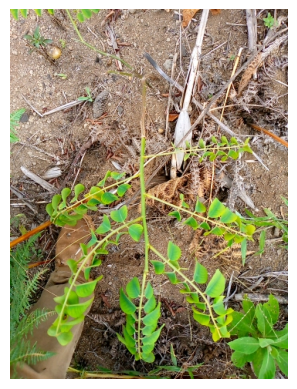

Confidence is 0.7669207665401111


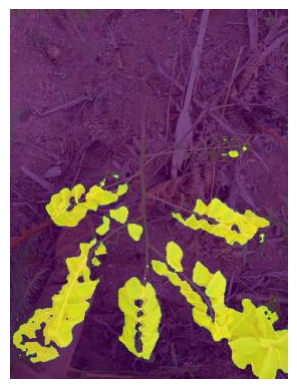

In [15]:
get_overlayed_mask(downstreamed_large, img_link)